In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-4/test.csv
/kaggle/input/covid19-global-forecasting-week-4/train.csv
/kaggle/input/covid19-global-forecasting-week-4/submission.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer,LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense,LSTM
import tensorflow as tf

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
test_df = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
submission = pd.read_csv("../input/covid19-global-forecasting-week-4/submission.csv")

In [4]:
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
test_df.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


In [6]:
train_df.isna().sum()

Id                    0
Province_State    20700
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [7]:
test_df.isna().sum()

ForecastId           0
Province_State    7740
Country_Region       0
Date                 0
dtype: int64

In [8]:
train_df['Province_State'].fillna("",inplace = True)
test_df['Province_State'].fillna("",inplace = True)

In [9]:
train_df['Country_Region'] = train_df['Country_Region'] + ' ' + train_df['Province_State']
test_df['Country_Region'] = test_df['Country_Region'] + ' ' + test_df['Province_State']
del train_df['Province_State']
del test_df['Province_State']

In [10]:
train_df.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,2020-01-26,0.0,0.0


In [11]:
def split_date(date):
    date = date.split('-')
    date[0] = int(date[0])
    if(date[1][0] == '0'):
        date[1] = int(date[1][1])
    else:
        date[1] = int(date[1])
    if(date[2][0] == '0'):
        date[2] = int(date[2][1])
    else:
        date[2] = int(date[2])    
    return date
train_df.Date = train_df.Date.apply(split_date)
test_df.Date = test_df.Date.apply(split_date)

In [12]:
train_df.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,"[2020, 1, 22]",0.0,0.0
1,2,Afghanistan,"[2020, 1, 23]",0.0,0.0
2,3,Afghanistan,"[2020, 1, 24]",0.0,0.0
3,4,Afghanistan,"[2020, 1, 25]",0.0,0.0
4,5,Afghanistan,"[2020, 1, 26]",0.0,0.0


In [13]:
year = []
month = []
day = []
for i in train_df.Date:
    year.append(i[0])
    month.append(i[1])
    day.append(i[2])

In [14]:
train_df['Year'] = year
train_df['Month'] = month
train_df['Day'] = day
del train_df['Date']

In [15]:
year = []
month = []
day = []
for i in test_df.Date:
    year.append(i[0])
    month.append(i[1])
    day.append(i[2])

In [16]:
test_df['Year'] = year
test_df['Month'] = month
test_df['Day'] = day
del test_df['Date']
del train_df['Id']
del test_df['ForecastId']

In [17]:
train_df.head()

,Country_Region,ConfirmedCases,Fatalities,Year,Month,Day
0,Afghanistan,0.0,0.0,2020,1,22
1,Afghanistan,0.0,0.0,2020,1,23
2,Afghanistan,0.0,0.0,2020,1,24
3,Afghanistan,0.0,0.0,2020,1,25
4,Afghanistan,0.0,0.0,2020,1,26


In [18]:
test_df.head()

,Country_Region,Year,Month,Day
0,Afghanistan,2020,4,2
1,Afghanistan,2020,4,3
2,Afghanistan,2020,4,4
3,Afghanistan,2020,4,5
4,Afghanistan,2020,4,6


In [19]:
train_df.Year.unique(),test_df.Year.unique()

(array([2020]), array([2020]))

In [20]:
del train_df['Year']
del test_df['Year']

In [21]:
train_df['ConfirmedCases'] = train_df['ConfirmedCases'].apply(int)
train_df['Fatalities'] = train_df['Fatalities'].apply(int)

In [22]:
cases = train_df.ConfirmedCases
fatalities = train_df.Fatalities
del train_df['ConfirmedCases']
del train_df['Fatalities']

In [23]:
lb = LabelEncoder()
train_df['Country_Region'] = lb.fit_transform(train_df['Country_Region'])
test_df['Country_Region'] = lb.transform(test_df['Country_Region'])

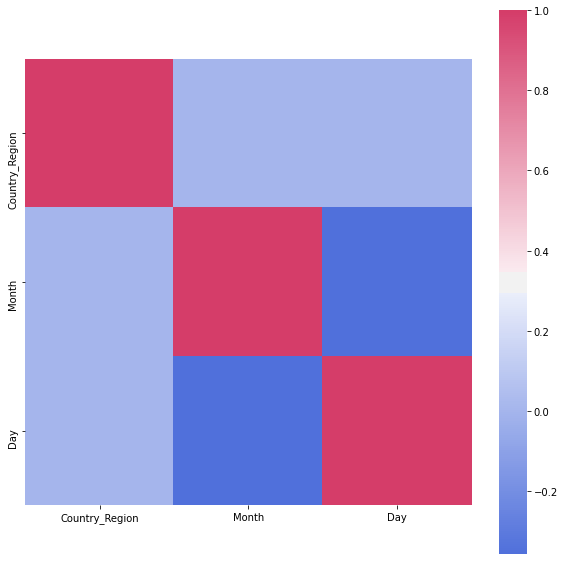

In [24]:
plt.figure(figsize = (10,10))
corr = train_df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [25]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_df.values)
x_test = scaler.transform(test_df.values)

In [26]:
from xgboost import XGBRegressor

In [27]:
rf = XGBRegressor(n_estimators = 2500 , random_state = 0 , max_depth = 27)
rf.fit(x_train,cases)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=27,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=2500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [28]:
cases_pred = rf.predict(x_test)
cases_pred

array([272.99905 , 281.0004  , 299.00058 , ...,  36.00076 ,  36.99918 ,
        37.001465], dtype=float32)

In [29]:
cases_pred = np.around(cases_pred,decimals = 0)
cases_pred

array([273., 281., 299., ...,  36.,  37.,  37.], dtype=float32)

In [30]:
x_train_cas = []
for i in range(len(x_train)):
    x = list(x_train[i])
    x.append(cases[i])
    x_train_cas.append(x)
x_train_cas[0]

[0.0, 0.0, 0.7, 0]

In [31]:
x_train_cas = np.array(x_train_cas)

In [32]:
rf = XGBRegressor(n_estimators = 2500 , random_state = 0 , max_depth = 27)
rf.fit(x_train_cas,fatalities)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=27,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=2500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [33]:
x_test_cas = []
for i in range(len(x_test)):
    x = list(x_test[i])
    x.append(cases_pred[i])
    x_test_cas.append(x)
x_test_cas[0]

[0.0, 0.75, 0.03333333333333333, 273.0]

In [34]:
x_test_cas = np.array(x_test_cas)

In [35]:
fatalities_pred = rf.predict(x_test_cas)
fatalities_pred

array([6.000111 , 6.000784 , 6.9994397, ..., 4.00011  , 3.9996495,
       3.9996495], dtype=float32)

In [36]:
fatalities_pred = np.around(fatalities_pred,decimals = 0)
fatalities_pred

array([6., 6., 7., ..., 4., 4., 4.], dtype=float32)

In [37]:
submission['ConfirmedCases'] = cases_pred
submission['Fatalities'] = fatalities_pred

In [38]:
submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0


In [39]:
submission.to_csv("submission.csv" , index = False)